In [1]:
%load_ext autoreload
%autoreload 2

import torch
from pytorch3d.io import load_obj, load_objs_as_meshes

from text3d2video.utilities.camera_placement import (
    cam_view_prompt,
    turntable_extrinsics,
)
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.mesh_processing import normalize_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

from text3d2video.rendering import render_depth_map

torch.set_grad_enabled(False)

In [2]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texgen_pipeline import TexGenConfig, TexGenPipeline
from diffusers.schedulers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(TexGenPipeline, sd_repo, controlnet_repo, DDIMScheduler)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

n_frames = 10
dist = 6.5

# angles = torch.linspace(0, 180, 7)
angles = [0, 40, 140, 180, 220, 320]
# angles = [0, 40]
# angles = torch.linspace(30, 150, 10)
# angles = torch.linspace(-50, 50, 5)

R, T = turntable_extrinsics(dists=dist, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
frame_meshes = mesh.extend(len(frame_cams))

prompt_suffixes = []
for angle in angles:
    view = cam_view_prompt(angle, 0)
    prompt_suffixes.append(f", {view} view")


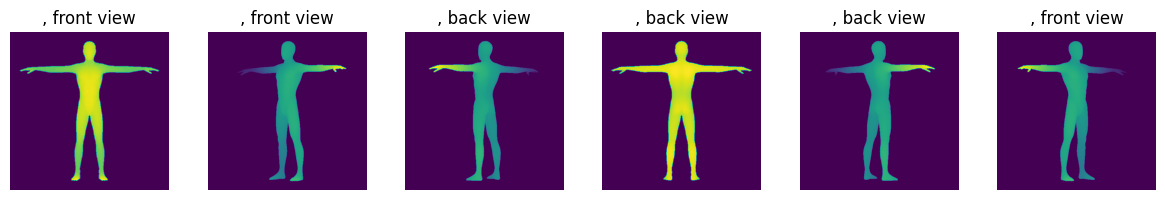

In [31]:
depths = render_depth_map(frame_meshes, frame_cams)
prompt = "Stormtrooper"
display_ims(depths, titles=prompt_suffixes)

In [1]:
from pathlib import Path
from text3d2video.utilities.logging import H5Logger

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

texgen_config = TexGenConfig(
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(1)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

images = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    texgen_config=texgen_config,
    generator=generator,
    prompt_suffixes=prompt_suffixes,
    logger=logger,
)

logger.close()

NameError: name 'TexGenConfig' is not defined

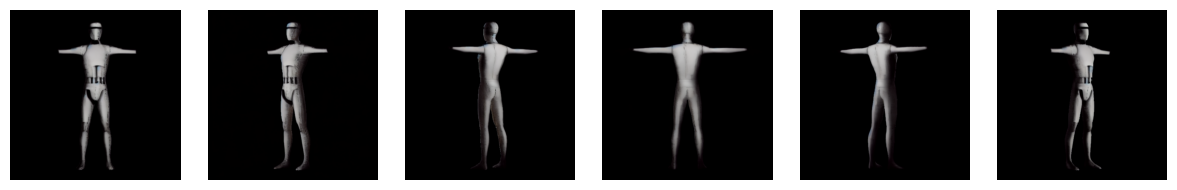

In [67]:
display_ims(images)

In [68]:
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip

display_vid(pil_frames_to_clip(images))

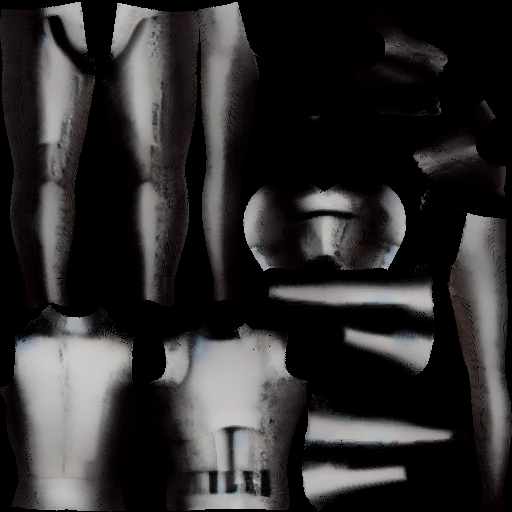

In [69]:
import torchvision.transforms.functional as TF

from text3d2video.backprojection import (
    aggregate_views_uv_texture,
    project_visible_texels_to_camera,
)

# texture_ims = [TF.to_tensor(x) for x in images]
# texture_ims = torch.stack(texture_ims).to(device)
# uv_map = aggregate_views_uv_texture(
#     texture_ims, uv_res, texel_xys, texel_uvs, interpolation_mode="bilinear"
# )

# TF.to_pil_image(uv_map.permute(2, 0, 1))

uv_res = 512
projections = [
    project_visible_texels_to_camera(m, c, verts_uvs, faces_uvs, uv_res)
    for m, c in zip(frame_meshes, frame_cams)
]

texture_ims = [TF.to_tensor(x) for x in images]
texture_ims = torch.stack(texture_ims).to(device)
xys = [p.xys for p in projections]
uvs = [p.uvs for p in projections]
uv_map = aggregate_views_uv_texture(
    texture_ims, uv_res, xys, uvs, interpolation_mode="bilinear"
)

TF.to_pil_image(uv_map.permute(2, 0, 1))

In [70]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_texture


anim = AnimationArtifact.from_wandb_artifact_tag("mma:latest")
indices = anim.frame_indices(20)
anim_cams, anim_meshes = anim.load_frames(indices)
anim_verts_uvs, anim_faces_uvs = anim.uv_data()

rendered_anim = render_texture(
    anim_meshes, anim_cams, uv_map, anim_verts_uvs, anim_faces_uvs
)
rendered_anim = [TF.to_pil_image(x) for x in rendered_anim]
display_vid(pil_frames_to_clip(rendered_anim))

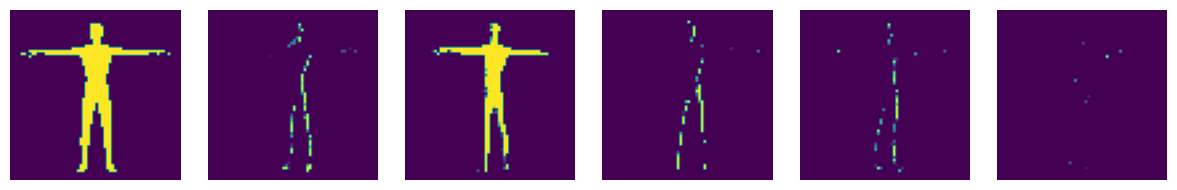

In [36]:
logger.open_read()

ts = sorted(logger.key_values("denoised", "t"), reverse=True)
frames = sorted(logger.key_values("mask", "frame_i"))

masks = [logger.read("mask", frame_i=f)[0] for f in frames]
display_ims(masks)

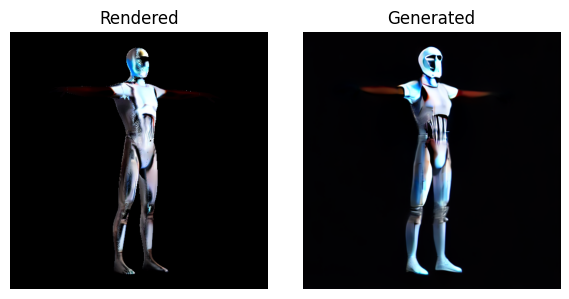

In [45]:
from einops import rearrange
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF

from text3d2video.util import pil_latent

t = ts[3]
frame_i = frames[5]
kwargs = dict(t=t, frame_i=frame_i)

# get rendered clean image
rendered = logger.read("rendered_clean", **kwargs)
rendered_latent = logger.read("rendered_latent", **kwargs)

# bring to noise level
rendered_noisy = logger.read("rendered_noisy", **kwargs)

# blend latent and rendered_noisy with mask
mask = logger.read("mask", frame_i=frame_i)
latent = logger.read("latent", **kwargs)
blended_latent = logger.read("blended_latent", **kwargs)

denoised = logger.read("denoised", **kwargs)
denoised_rgb = logger.read("denoised_rgb", **kwargs)

# final clean tex
clean_tex = logger.read("clean_tex", **kwargs)

display_ims(
    [TF.to_pil_image(x) for x in [rendered, denoised_rgb]],
    titles=["Rendered", "Generated"],
    scale=3,
)

# TF.to_pil_image(rendered)
# pil_latent(rendered_latent)
# pil_latent(rendered_noisy)
# pil_latent(latent)
# pil_latent(blended_latent)
# pil_latent(denoised)
# TF.to_pil_image(denoised_rgb)
# TF.to_pil_image(rearrange(clean_tex, "h w c -> c h w"))